In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score, classification_report
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import ipywidgets as widgets
from IPython.display import display, clear_output
from pandas.io.formats import style
from IPython.core.display import display
from ipywidgets import Button, GridBox, Layout, ButtonStyle


%matplotlib inline

initial_df = pd.read_csv("insurance.csv")

# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

In [2]:
initial_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [3]:
df.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese',
       'obese_smoker'],
      dtype='object')

In [30]:
#widgets
style = {'description_width': 'initial'}

widget_sex = widgets.Select(
    options = sorted(initial_df['sex'].unique().tolist()),
    description = 'Sex',
    style = style,
    disabled = False,
    layout = {'width': 'max-content'})

widget_region = widgets.Select(
    options = sorted(initial_df['region'].unique().tolist()),
    description = 'Region',
    style = style,
    disabled = False,
    layout = {'width': 'max-content'})

widget_age = widgets.IntSlider(
    min = initial_df['age'].min(),
    max = 100,
    description = 'Age',
    style = style)

widget_height = widgets.IntSlider(
    min = 120,
    max = 200,
    description = 'Height [cm]',
    style = style)

widget_weight = widgets.FloatSlider(
    min = 35,
    max = 200,
    description = 'Weight [kg]',
    style = style)

widget_children = widgets.IntSlider(
    min = initial_df['children'].min(),
    max = 8,
    description = 'Children',
    style = style)

widget_smoker = widgets.RadioButtons(
    options=[('Yes',1), ('No',0)],
    style=style,
    disabled = False,
    description='Smoker')

# widget_smoker = widgets.Select(
#     options = ['Yes', 'No'],
#     description = 'Smoker',
#     style = style,
#     disabled = False,
#     layout = {'width': 'max-content'})

In [31]:
#widget handler

values = {'sex_dropdown': widget_sex.value,
          'region_dropdown': widget_region.value,
          'age_slider': widget_age.value,
          'height_slider': widget_height.value,
          'weight_slider': widget_weight.value,
          'children_slider': widget_children.value,
          'smoker_button': widget_smoker.value}
def widgets_handler(sex_dropdown_val,
                    region_dropdown_val,
                    age_slider_val,
                    height_slider_val,
                    weight_slider_val,
                    children_slider_val,
                    smoker_button_val):
    values['sex_dropdown'] = sex_dropdown_val
    values['region_dropdown'] = region_dropdown_val
    values['age_slider'] = age_slider_val
    values['height_slider'] = height_slider_val
    values['weight_slider'] = weight_slider_val
    values['children_slider'] = children_slider_val
    values['smoker_button'] = smoker_button_val

In [32]:
#run button
run_button = widgets.Button(description="Predict")
from IPython.display import clear_output

def button_callback(button):
    age=values['age_slider']
    bmi=values['weight_slider']/(values['height_slider']/100)**2
    children=values['children_slider']
    smoker_yes=values['smoker_button']
    if values['region_dropdown']=='northwest':
        region_northwest=1
        region_southeast=0
        region_southwest=0
    elif values['region_dropdown']=='southeast':
        region_northwest=0
        region_southeast=1
        region_southwest=0
    elif values['region_dropdown']=='southwest':
        region_northwest=0
        region_southeast=0
        region_southwest=1
    else:
        region_northwest=0
        region_southeast=0
        region_southwest=0
    if bmi>=30:
        obese=1
    else:
        obese=0
    if bmi>=30 & smoker_yes==1:
        obese_smoker=1
    else:
        obese_smoker=0
    if values['sex_dropdown']=='male':
        sex_male=1
    else:
        sex_male=0
        
    values_to_predict= [age, bmi, children, sex_male, smoker_yes, region_northwest, region_southeast,
          region_southwest, obese, obese_smoker]
    columns=['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese', 'obese_smoker']
    to_predict=pd.DataFrame([values_to_predict],columns=columns)
    return print(xgb_model.predict(to_predict))
run_button.on_click(button_callback)

In [33]:
filters = GridBox(children=[widget_sex, widget_region, widget_smoker, widget_age, 
                            widget_height, widget_weight, widget_children,
                            run_button],
                    layout=Layout(
                    width='100%',
                    grid_template_columns='300px 300px 300px',
                    grid_template_rows='auto auto auto',
                    grid_gap='5px 10px')
               )

In [34]:
display(filters)

GridBox(children=(Select(description='Sex', layout=Layout(width='max-content'), options=('female', 'male'), st…

In [9]:
import pickle
# Load the Model back from file
Pkl_Ridge = 'pickled_ridge_model.pkl'  
Pkl_EN = 'pickled_en_model.pkl'  
Pkl_XGB = 'pickled_xgb_model.pkl'  
Pkl_Stacked = 'pickled_stacked_model.pkl'
Pkl_data='pickled_data'


with open(Pkl_Ridge, 'rb') as file1:  
    ridge_model = pickle.load(file1)

with open(Pkl_EN, 'rb') as file2:  
    en_model = pickle.load(file2)
    
with open(Pkl_XGB, 'rb') as file3:  
    xgb_model = pickle.load(file3)

with open(Pkl_Stacked, 'rb') as file4:  
    stacked_model = pickle.load(file4)
    
with open(Pkl_data, 'rb') as file4:  
    df = pickle.load(file4)


In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.900,0,0,1,0,0,1,0,0
1,18,33.770,1,1,0,0,1,0,1,0
2,28,33.000,3,1,0,0,1,0,1,0
3,33,22.705,0,1,0,1,0,0,0,0
4,32,28.880,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,1,0,0,1,0
1334,18,31.920,0,0,0,0,0,0,1,0
1335,18,36.850,0,0,0,0,1,0,1,0
1336,21,25.800,0,0,0,0,0,1,0,0


In [11]:
ridge_model.score(X_test,y_test)

0.8712125654141842

In [12]:
en_model.score(X_test,y_test)

0.8711719305610985

In [13]:
xgb_model.score(X_test,y_test)

0.8730627049627262

In [14]:
# bardziej powtarzalny, lepszy wynik z CV
stacked_model.score(X_test,y_test)

0.8728794330786501

In [15]:
en_model.predict(X_train)

array([13913.64195573,  8829.70456694, 13185.04512187, 45486.8907723 ,
       39309.35166281, 43184.34438114,  6788.31663564,  5238.60045379,
       14388.70942618,  9098.42939517, 43581.93851328,  3132.92222867,
        8818.53356615, 12306.81735487, 21402.07861398,  5324.71996996,
        4235.52560878, 13853.06951407,  5295.56958126,  5801.90713228,
        9114.06570148,   956.66372037, 20969.55010816, 10438.62732921,
        7793.11413168,  4988.06961942,  6679.69285469, 13480.21476756,
       19188.72568481, 10468.5391609 ,  9146.37114738,  6331.9480034 ,
        7929.1897942 ,  2881.52100456,  7860.74567204,  9750.7286233 ,
       11635.24311388, 10510.03065924,  7414.31506644,  3205.48545008,
        9508.61249847, 41363.70142044, 43334.48807913,  2012.23576324,
       46444.18791274, 35933.87533802, 12009.75892844,  1874.39217718,
       14303.99937297,  1737.38843694,  9782.9640594 , 38022.57037953,
       15351.1705075 , 12024.31577246,  8876.77254835, 13364.17853408,
      

In [26]:
predykcja = en_model.predict(pd.DataFrame([[20,25, 3, 0, 1, 1, 0, 0, 1, 1]], columns=['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese', 'obese_smoker']))
predykcja

array([37101.0327961])

In [18]:
({'age':20,'bmi':25, 'children':3,'sex_male':0,'smoker_yes':1,
                  'region_northwest':1,'region_southeast':0,'region_southwest':0,'obese':1,'obese_smoker':1})

{'age': 20,
 'bmi': 25,
 'children': 3,
 'sex_male': 0,
 'smoker_yes': 1,
 'region_northwest': 1,
 'region_southeast': 0,
 'region_southwest': 0,
 'obese': 1,
 'obese_smoker': 1}

#### Ewaluacja modeli

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from math import sqrt

In [22]:
from sklearn import set_config
import time

In [23]:
def run_model(pipeline, Xtrain, ytrain, Xtest, ytest):
    set_config(display='diagram')
    pd.options.display.float_format = "{:,.2f}".format
    
    y_pred_train = pipeline.predict(Xtrain).reshape(-1,1)
    y_pred_test = pipeline.predict(Xtest).reshape(-1,1)
    pipeline_name = display(pipeline)
    
    start_time = time.time()
    pipeline.fit(Xtrain, ytrain)
    end_time = time.time()
    
    wyniki = {}
    wyniki['score'] = ['R^2', 'MSE', 'RMSE', 'MAE']
    wyniki['train_set'] = []
    wyniki['test_set'] = []
    
    r2_train_set = pipeline.score(Xtrain, ytrain) * 100
    MSE_train_set = mean_squared_error(ytrain, y_pred_train)
    RMSE_train_set = sqrt(mean_squared_error(ytrain, y_pred_train))
    MAE_train_set = mean_absolute_error(ytrain, y_pred_train)
    
    wyniki['train_set'].append(r2_train_set)
    wyniki['train_set'].append(MSE_train_set)
    wyniki['train_set'].append(RMSE_train_set)
    wyniki['train_set'].append(MAE_train_set)
    
    r2_test_set = pipeline.score(Xtest, ytest) * 100
    MSE_test_set = mean_squared_error(ytest, y_pred_test)
    RMSE_test_set = sqrt(mean_squared_error(ytest, y_pred_test))
    MAE_test_set = mean_absolute_error(ytest, y_pred_test)
    
    wyniki['test_set'].append(r2_test_set)
    wyniki['test_set'].append(MSE_test_set)
    wyniki['test_set'].append(RMSE_test_set)
    wyniki['test_set'].append(MAE_test_set)    
    
    cross_val = cross_val_score(pipeline, Xtrain, ytrain, cv=5).mean()
    
    df_wyniki = pd.DataFrame(wyniki)
    
    print(df_wyniki)
    print('\nCross validation score: {0:.2f}%'.format(100 * cross_val))
    print('Time elapsed: {0:.3f} sec'.format(end_time - start_time))
    
    x_ax = range(len(y_test))
    plt.scatter(x_ax, ytest, label='original')
    plt.scatter(x_ax, y_pred_test, label='predicted')
    plt.title('Test and predicted data')
    plt.legend()
    plt.show()
    
    return pipeline.fit(Xtrain, ytrain)

In [24]:
models = [ridge_model, en_model, xgb_model, stacked_model]

Ridge()

  score     train_set      test_set
0   R^2         86.04         87.12
1   MSE 20,443,271.72 18,883,368.46
2  RMSE      4,521.42      4,345.50
3   MAE      2,539.09      2,424.17

Cross validation score: 85.17%
Time elapsed: 0.003 sec


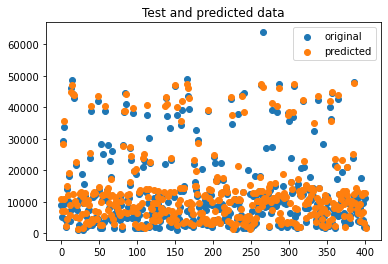

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.01))])

  score     train_set      test_set
0   R^2         86.05         87.12
1   MSE 20,438,964.80 18,889,326.52
2  RMSE      4,520.95      4,346.19
3   MAE      2,538.58      2,424.30

Cross validation score: 85.17%
Time elapsed: 0.005 sec


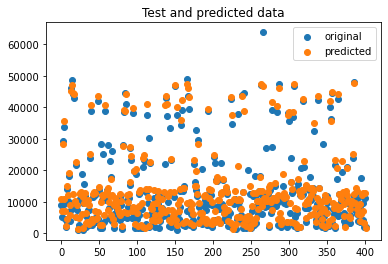

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('xgbregressor',
                 XGBRegressor(alpha=0, base_score=0.5, booster='gblinear',
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              feature_selector='greedy', gamma=None, gpu_id=-1,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.09,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=16, num_parallel_tree=None, predictor=None,
                              random_state=0, reg_alpha=0, reg_lambda=0.001,
                              scale_pos_weight=1, subsample=None, top_k=7,
                              tree_method=None, updater='coord_descent', ...))])

  score     train_set      test_set
0   R^2         86.72         87.31
1   MSE 19,456,763.67 18,612,093.03
2  RMSE      4,410.98      4,314.17
3   MAE      2,433.66      2,375.30

Cross validation score: 85.22%
Time elapsed: 0.129 sec


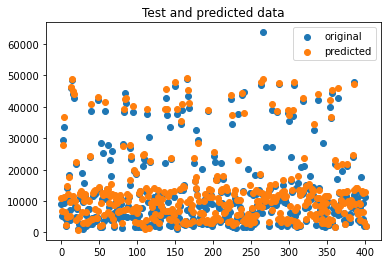

StackingRegressor(estimators=[('en',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.01))])),
                              ('ridge', Ridge()),
                              ('xgb',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('polynomialfeatures',
                                                PolynomialFeatures(interaction_only=True)),
                                               ('xgbregressor',
                                                XGBRegressor(alpha=0,
                                                             base_score=0.5,
                                                             booster='gblinear',
                                                             colsampl...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.09,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=16,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=0,
                                                             reg_alpha=0,
                                                             reg_lambda=0.001,
                                                             scale_pos_weight=1,
                                                             subsample=None,
                                                             top_k=7,
                                                             tree_method=None,
                                                             updater='coord_descent', ...))]))])

  score     train_set      test_set
0   R^2         86.53         87.29
1   MSE 19,735,920.53 18,638,965.14
2  RMSE      4,442.51      4,317.29
3   MAE      2,453.28      2,382.37

Cross validation score: 85.25%
Time elapsed: 0.782 sec


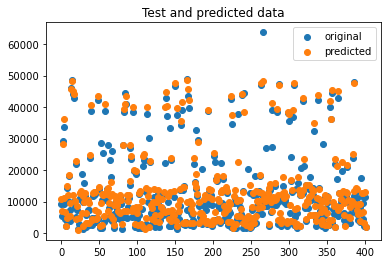

In [25]:
for model in models:
    run_model(model, X_train, y_train, X_test, y_test)

#### Wizuaizacja danych klienta

In [57]:
# dodanie progow oplat
df['charges_thresholds'] = 0

# progi:
IV_opis = '> 30.000'
III_opis = '15.000 - 30.000'
III_prog = 30000
II_prog = 15000
II_opis = '6.000 - 15.000'
I_prog = 6000
I_opis = '< 6.000'

for index, row in df.iterrows():
    if row['charges'] > III_prog:
        df.loc[index,'charges_thresholds'] = IV_opis
    elif row['charges'] < I_prog:
        df.loc[index,'charges_thresholds'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        df.loc[index,'charges_thresholds'] = II_opis
    else:
        df.loc[index,'charges_thresholds'] = III_opis
        
# df.groupby('charges_thresholds').mean()

In [45]:
# dana z predykcji
customer_fee = predykcja 

In [46]:
# !!!!!!!!!!!!!!! obliczenie bmi z widgetow -> do usunięcia po poprawce w widgetach
customer_bmi = values['weight_slider'] / (values['height_slider']/100)**2
customer_bmi

31.249999999999993

In [47]:
# !!!!!!!!!!!!!! ze wzgledu na nie przejmowanie przez slownik danych z widgetow, wstawione na razie dane recznie
values['height_slider']=160
values['weight_slider']=80
values['age_slider']=35

In [48]:
values

{'sex_dropdown': 'female',
 'region_dropdown': 'northeast',
 'age_slider': 35,
 'height_slider': 160,
 'weight_slider': 80,
 'children_slider': 0,
 'smoker_button': 1}

In [49]:
# df dla danych klienta
lista_customer = [[customer_bmi, 
                   values['age_slider'], 
                   customer_fee]]

df_customer = pd.DataFrame(lista_customer)
df_customer.columns = ['bmi_custom', 'age_customer', 'customer_fee']

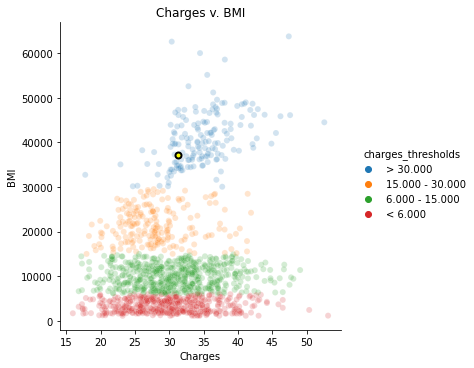

In [50]:
# wykres charges v. BMI z uwzglednieniem danych klienta z widget
ax_1 = sns.relplot(data=df, x='bmi', y='charges', hue='charges_thresholds',
               hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],
               alpha=0.2)
(ax_1.map(plt.scatter, x=df_customer['bmi_custom'], y=df_customer['customer_fee'], 
       color='yellow', marker='o', edgecolors='black', linewidths=2)
  .tight_layout(w_pad=0))
plt.title('Charges v. BMI')
plt.xlabel('Charges')
plt.ylabel('BMI')
plt.show()

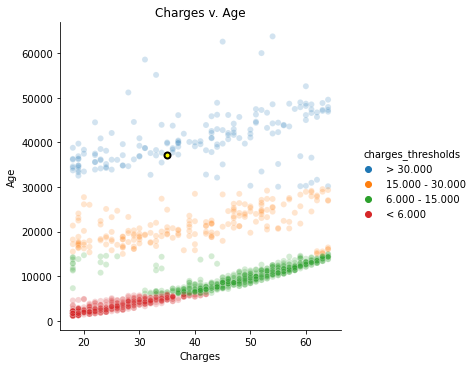

In [51]:
# wykres charges v. age z uwzglednieniem danych klienta z widget
ax_2 = sns.relplot(data=df, x='age', y='charges', hue='charges_thresholds',
               hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],
               alpha=0.2)
(ax_2.map(plt.scatter, x=df_customer['age_customer'], y=df_customer['customer_fee'], 
       color='yellow', marker='o', edgecolors='black', linewidths=2)
  .tight_layout(w_pad=0))
plt.title('Charges v. Age')
plt.xlabel('Charges')
plt.ylabel('Age')
plt.show()

In [52]:
group_1 = df[df['charges'] < I_prog]
group_2 = df[df['charges'] < II_prog]
group_3 = df[df['charges'] <= III_prog]
group_4 = df[df['charges'] > III_prog]

In [53]:
group_1.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,429.00,26.05,6.33,18.00,18.00,20.00,25.00,31.00,35.00,42.00
bmi,429.00,30.04,6.22,15.96,22.21,25.80,29.92,34.10,38.43,53.13
children,429.00,0.81,1.08,0.00,0.00,0.00,0.00,1.00,2.00,5.00
charges,429.00,"3,393.00","1,390.28","1,121.87","1,645.06","2,138.07","3,279.87","4,564.19","5,357.93","5,989.52"
sex_male,429.00,0.50,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
smoker_yes,429.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
region_northwest,429.00,0.25,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,429.00,0.29,0.46,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,429.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
obese,429.00,0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [54]:
group_2.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,980.00,38.85,13.98,18.00,19.00,26.00,39.00,51.00,58.00,64.00
bmi,980.00,30.49,6.15,15.96,22.61,26.10,30.20,34.32,38.68,53.13
children,980.00,1.06,1.21,0.00,0.00,0.00,1.00,2.00,3.00,5.00
charges,980.00,"7,112.21","3,869.93","1,121.87","2,097.57","3,701.62","6,789.11","10,411.04","12,629.24","14,988.43"
sex_male,980.00,0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00
smoker_yes,980.00,0.01,0.08,0.00,0.00,0.00,0.00,0.00,0.00,1.00
region_northwest,980.00,0.25,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,980.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,980.00,0.26,0.44,0.00,0.00,0.00,0.00,1.00,1.00,1.00
obese,980.00,0.52,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00


In [55]:
group_3.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,"1,176.00",39.05,13.99,18.00,19.00,26.00,39.00,51.00,58.00,64.00
bmi,"1,176.00",30.09,6.04,15.96,22.61,25.79,29.70,33.89,38.18,53.13
children,"1,176.00",1.09,1.21,0.00,0.00,0.00,1.00,2.00,3.00,5.00
charges,"1,176.00","9,483.41","6,565.95","1,121.87","2,203.60","4,348.85","8,246.44","12,629.35","19,567.03","29,523.17"
sex_male,"1,176.00",0.49,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00
smoker_yes,"1,176.00",0.10,0.31,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_northwest,"1,176.00",0.25,0.43,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southeast,"1,176.00",0.26,0.44,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,"1,176.00",0.24,0.43,0.00,0.00,0.00,0.00,0.00,1.00,1.00
obese,"1,176.00",0.47,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [56]:
group_4.describe(percentiles=[.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
age,162.00,40.38,14.47,18.00,20.00,27.00,42.00,52.75,60.00,64.00
bmi,162.00,34.85,4.74,17.77,30.21,31.69,34.65,37.03,40.88,52.58
children,162.00,1.17,1.14,0.00,0.00,0.00,1.00,2.00,3.00,4.00
charges,162.00,"40,761.31","6,165.96","30,063.58","33,901.34","36,203.13","39,854.11","44,482.00","47,924.91","63,770.43"
sex_male,162.00,0.64,0.48,0.00,0.00,0.00,1.00,1.00,1.00,1.00
smoker_yes,162.00,0.94,0.24,0.00,1.00,1.00,1.00,1.00,1.00,1.00
region_northwest,162.00,0.18,0.38,0.00,0.00,0.00,0.00,0.00,1.00,1.00
region_southeast,162.00,0.38,0.49,0.00,0.00,0.00,0.00,1.00,1.00,1.00
region_southwest,162.00,0.23,0.42,0.00,0.00,0.00,0.00,0.00,1.00,1.00
obese,162.00,0.92,0.27,0.00,1.00,1.00,1.00,1.00,1.00,1.00
